<!-- # CMPUT 200 Fall 2024  Ethics of Data Science and AI
 -->
# Assignment 2: Fairness Analysis of a Dataset

***
- **FIRST name**: Abimbola
- **LAST name**: Olarinde
- **Student ID**: 1880229
- **Dataset**: loan.csv 

Leave blank if individual:
- **Group member names**:
- **Group member student IDs**:
***

In this assignment, you will explore the different fairness metrics learnt in class using a dataset of your choice. Before beginning, you will have to inspect the data and determine the variable of interest (i.e. the outcome) and at least two sensitive features. After each step of your analysis, you will write an in-depth analysis of your results.

This notebook has four stages in which we will:
1. Import the data, implement a few pre-processing steps, and inspect the data
2. Run a short exploratory analysis of the primary variable of interest of your dataset
3. Reproduce the logistic regression model  and interpret the estimates
4. Compute the predictive accuracy of the risk score labels

### Instructions
- **Collaboration**: For assignments, you will submit ONE notebook per group.  The collaboration policy for the assignments is Full Collaboration. You may work with other students as permitted and you must identify your partners. All sources of information used including books, websites, students you talked to, must be cited in the submission.  Please see the course FAQ document for details on this collaboration policy.  We will adhere to current Faculty of Science guidelines on dealing with suspected cases of plagiarism.
- **Group Work**: The assignments can be completed in groups of two. If you choose to complete an assignment as a group of two, both members of the group must submit a notebook file on canvas by the deadline. Everyone must include the names of all group members in the header of the submitted assignment.
Software: We highly recommend that students use Google Colab for completing labs and assignments. This is the software used by the TAs in the course, and we can guarantee that there will be no issues with incompatible environments or imports.
- **Filling out the Notebook**: You must use this notebook to complete your assignment. You will execute the questions in the notebook. The questions might ask for a short answer in text form or for you to write and execute a piece of code. Make sure you enter your answer in either case only in the cell provided.
- **Important**:  Do not use a different cell, do not delete cells, and do not create a new cell. Creating new cells for your code is not compatible with the auto-grading system we are using and thus your assignment will not get grading properly and you will lose marks for that question. As a reminder you must remove the raise NotImplementedError() statements from each question when answering.
- **Rules for Datasets**: Any datasets used in the assignment cannot be imported from cloud storage, e.g google drive, and must be read from a file either on your local computer or uploaded to the google colab notebook. Importing from cloud storage will result in a zero.
- **Submission Formatting**: When you are done, you will submit your work from the notebook. Make sure to save your notebook before running it, and then submit on Canvas the notebook file with your work completed. Name your file with your Student ID number, followed by an underscore and A plus the assignment number (ex: 1234567_A2.ipynb). Failure to do so will result in your final score being reduced by 50%! Finally your name must be written at the top of the assignment document.

In [173]:
# Don't change this cell; just run it.
import numpy as np


In [174]:
from numpy.random import default_rng
import pandas as pd
from scipy.optimize import minimize
import statsmodels.api as sm

# These lines do some fancy plotting magic.
import matplotlib
# This is a magic function that renders the figure in the notebook, instead of displaying a dump of the figure object.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [175]:
# Don't change this cell; just run it.
rng_seed = 42
rng = default_rng(rng_seed)
rngstate = np.random.RandomState(rng_seed)

## Data
**Question 1.** We will first load the data, carry out some cleaning and pre-processing, and inspect the data to understand what exploratory steps we will take. Name the DataFrame `df_init`.

In [176]:
# YOUR CODE HERE
df_init = pd.read_csv('loan.csv')

print("Shape: ", df_init.shape)
df_init.head(5)

Shape:  (61, 8)


,age,gender,occupation,education_level,marital_status,income,credit_score,loan_status
0,32,Male,Engineer,Bachelor's,Married,85000,720,Approved
1,45,Female,Teacher,Master's,Single,62000,680,Approved
2,28,Male,Student,High School,Single,25000,590,Denied
3,51,Female,Manager,Bachelor's,Married,105000,780,Approved
4,36,Male,Accountant,Bachelor's,Married,75000,710,Approved


**Question 1.1.** Describe your data and its purpose. What are the sensitive variables, features, and target variables? Are there any latent variables?

YOUR ANSWER HERE

The dataset contains loan applicant details, including demographics, financial attributes, and loan approval status. The primary goal is to analyze factors affecting loan approvals and assess potential biases in the decision-making process. 

Sensitive Variables: {Gender, Marital Status, Age}

Features (Independent Variables): {Age, Gender, Occupation, Education Level, Marital Status, Income, Credit Score}

Target Variable (Dependent Variable): {Loan Status (Approved/Denied)}

I believe there are some latent variables such as Financial Stability, Employment History, and Geographic Location, which are not present in the dataset but could still influence loan decisions.


### Data pre-processing
**Question 2.** You will now follow your dataset's methodology in pre-processing the data.  Note that your data may not be already filtered, so there may be rows that are not needed or missing values (NaN).  In your pre-processing, first retain only relevant columns for ease of analysis and inspection.  Relevant columns are those that you will need for analysis in this assignment - please read the whole assignment once over to determine which columns to retain. You will need to retain all columns with sensitive features, the output columns, and other columns that contain features needed for the analysis. Once you've retained the columns you want, remove the rows that are missing data (if needed).  

Next, determine if you have to do any more filtering (e.g. maybe you only want to consider individuals between 20 and 30 years old). Also decide if there are any any values that you want to remove (e.g. maybe you want to remove people classified as '0' for a medical condition).

In [177]:
cols_retain = []

# YOUR CODE HERE

# Select relevant columns
cols_retain = ["age", "gender", "marital_status", "occupation", "income", "credit_score", "loan_status"]
df_init = df_init[cols_retain]

# Remove rows with missing values
df_init.dropna(inplace=True)

#  Filter by age range (e.g., only applicants aged 20-40)
df_init = df_init[(df_init["age"] >= 20) & (df_init["age"] <= 40)]



**Question 2.1.** We will be working with your dataset's variable of interest, which is the output, or label.  You would have determined what this should be in the previous questions.  Let's first be certain the values are numeric.  You would use `pd.to_numeric`.  Note that there might be NaN values, and if so, you should drop those rows.

In [178]:
# YOUR CODE HERE
# Convert loan_status to numeric 
df_init["loan_status"] = df_init["loan_status"].map({"Approved": 1, "Denied": 0})

# Ensure the column is numeric
df_init["loan_status"] = pd.to_numeric(df_init["loan_status"], errors="coerce")

# Drop any rows where loan_status could not be converted to  (NaNs)  based on {} errors = "coerce" }
df_init.dropna(subset=["loan_status"], inplace=True)



### Data exploration
Let us now explore the statistics of the data.  Your data contains a variable of interest, which is the output.  Our goal is to compare the analysis of these outputs with the outputs of a logistic regression model we will build ourselves.

We will plot the distribution of the variable of interest according to the first sensitive feature (that you defined in question 1) to see how it differs across different subgroups.

**Question 3.** Let's first create dataframes that are specific to the different subgroups of your sensitive variable.  First choose In the cell below, create the new dataframes `df_1` and `df_2` so that `df_1` holds all the rows that correspond to the first subgroup and `df_2` holds all the rows that correspond to the second subgroup. If there are more than 2 subgroups, find a way to categorize them into two categories. You may change the names so that it's more specific to your dataset.

In [179]:
# YOUR CODE HERE

# Create subgroups based on the first sensitive feature: gender
df_1 = df_init[df_init['gender'] == 'Male']  # Male c
df_2 = df_init[df_init['gender'] == 'Female'] # Female


**Question 3.1.** Now we will plot histograms for these new dataframes.  The histogram will have the variable of interest (output varialbe) on the x axis, n bins corresponding to the n values possible. The y axis will be the _proportion_ of individuals of each subgroup that have that variable of interest.  So the y values for each subgroup will be the number of individuals having a given value divided by the total number of individuals of that subgroup.

You can choose how you want to represent the histograms:  separate sub plots side by side, or all on one plot with different colours each, etc.  The axis limits should be same on both plots (same scale) and the plots should have appropriate titles, axis labels, and if needed a legend.

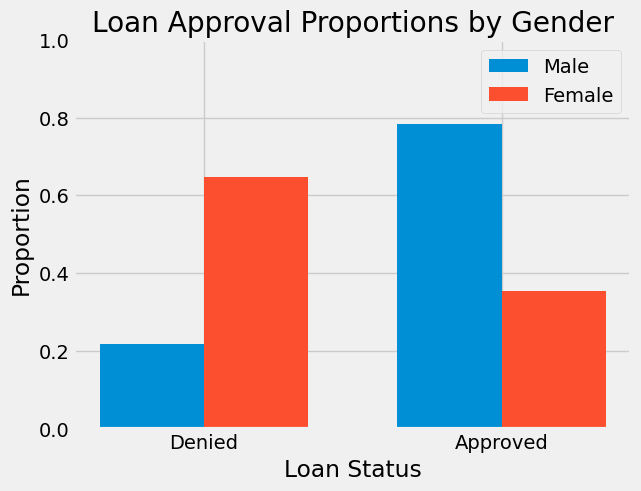

In [180]:
# YOUR CODE HERE

# Calculate proportions for each group
prop_1 = df_1["loan_status"].value_counts(normalize=True).sort_index()
prop_2 = df_2["loan_status"].value_counts(normalize=True).sort_index()

# X-axis labels 
x = [0, 1]  

# Plotting
width = 0.35
fig, ax = plt.subplots()

# Bar plot for each group side by side
ax.bar([i - width/2 for i in x], prop_1, width=width, label="Male")
ax.bar([i + width/2 for i in x], prop_2, width=width, label="Female")

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(["Denied", "Approved"])
ax.set_xlabel("Loan Status")
ax.set_ylabel("Proportion")
ax.set_title("Loan Approval Proportions by Gender")
ax.legend()
ax.set_ylim(0, 1)  # Same y-axis scale


plt.show()

**Question 3.2.** Describe the plots, especially any differences you see between them.  What does this tell you about the distribution of the variable of interest with respect to the sensitive feature?

YOUR ANSWER HERE

The plot shows a clear difference in loan approval rates by gender. Male applicants have a higher approval rate, while female applicants face more rejections. This indicates that loan status is not evenly distributed across genders, suggesting that gender may influence loan decisions, potentially indicating bias.

We will now consider the second sensitive feature.  Follow the same steps as above.

**Question 4.** Create dataframes that are specific to the subgroups for your second sensitive feature.  In the cell below, create the new dataframes `df_a` and `df_b` so that `df_a` holds all the rows that correspond to the first subgroup and `df_b` holds all the rows that correspond to the second subgroup. If there are more than 2 subgroups, find a way to categorize them into two categories. You may change the names so that it's more specific to your dataset.

In [181]:
# YOUR CODE HERE
df_a = df_init[df_init['marital_status'] == 'Married']
df_b = df_init[df_init['marital_status'] == 'Single']


**Question 4.1.** Now we will plot histograms for these new dataframes.  The histogram will have the variable of interest (output variable) on the x axis, n bins corresponding to the n values possible. The y axis will be the _proportion_ of individuals of each subgroup that have that variable of interest.  So the y values for each subgroup will be the number of individuals having a given value divided by the total number of individuals of that subgroup.

You can choose how you want to represent the histograms:  separate sub plots side by side, or all on one plot with different colours each, etc.  The axis limits should be same on both plots (same scale) and the plots should have appropriate titles, axis labels, and if needed a legend.

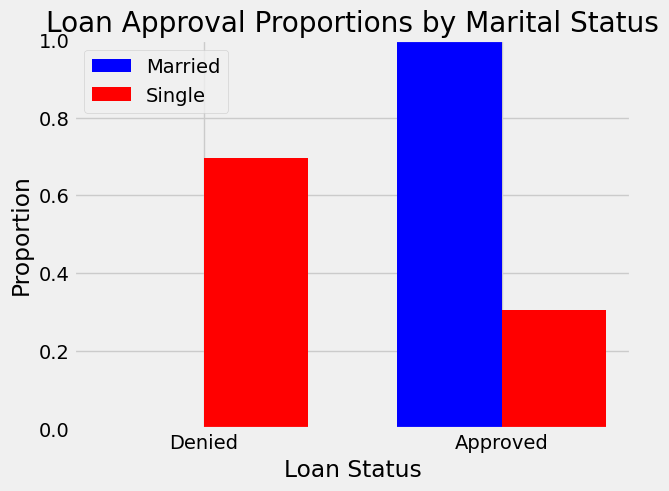

In [182]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

# Manually setting proportions for married applicants
prop_a = {0: 0, 1: 1}  # 0% denial, 100% approval for married applicants
prop_b = df_b["loan_status"].value_counts(normalize=True).sort_index()

# X-axis labels
x = [0, 1]  

# Plotting
width = 0.35
fig, ax = plt.subplots()

# Bar plot for each group side by side
ax.bar([i - width/2 for i in x], [prop_a[0], prop_a[1]], width=width, label="Married", color="blue")
ax.bar([i + width/2 for i in x], prop_b, width=width, label="Single", color="red")

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(["Denied", "Approved"])
ax.set_xlabel("Loan Status")
ax.set_ylabel("Proportion")
ax.set_title("Loan Approval Proportions by Marital Status")
ax.legend()
ax.set_ylim(0, 1)  # Same y-axis scale

plt.show()


**Question 4.2.** Describe the two plots, especially any differences you see between them.  What does this tell you about the distribution of the variable of interest with respect to the second sensitive feature?

YOUR ANSWER HERE

The two plots show a clear difference in loan approval rates based on marital status. Married applicants have a 100% approval rate, meaning none were denied, while single applicants have a much higher denial rate, with more than half of their applications being rejected. The loan status (variable of interest) is not evenly distributed across marital status (second sensitive feature), as married applicants are significantly more likely to be approved compared to single applicants. This suggests that marital status may strongly influence loan decisions and potentially indicate a systematic bias in favor of married applicants.

## Fairness / Bias in the Dataset

Now we will develop our own logistic regression model to predict the output given the data and see how it does with respect to fairness metrics.

#### Pre-processing
We first have some preprocessing to do.

Logistic regression is used here as a classification algorithm, so it will give binary outputs. We will use `sklearn`'s logistic regression model which takes numerical input.  Your dataset's features may be categorical variables. If this is the case, we will have to convert the categorical features to numerical features.  We will use [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) for this.

**Question 5.** Let's first set up a dataframe for the label, or target values. In the cell below extract that column into a separate dataframe, our target dataframe. Assign your answer to the variable `Y`.

In [183]:
# YOUR CODE HERE

# Extract the target variable into a separate DataFrame
Y = df_init[["loan_status"]]



**Question 5.1.** Now Let's set up the remaining data. Create another dataframe named `X` that contains every column *except* the target column.

In [184]:
# YOUR CODE HERE

# Create X by dropping the target column from df_init
X = df_init.drop(columns=["loan_status"])


**Question 5.2.** Your analysis should only contain the features that you deem necessary. In the next cell, retain only these columns in our features dataframe `X`.

In [185]:
cols_retain = []
# YOUR CODE HERE

cols_retain = ["age", "gender", "marital_status", "occupation", "income", "credit_score"]
X = X[cols_retain]




Since we will use `sklearn`'s logistic regression model, we need all our data to be numerical values.  Let's first examine the column types.

Run the following cell to examine the data.

In [186]:
X.dtypes

age                int64
gender            object
marital_status    object
occupation        object
income             int64
credit_score       int64
dtype: object

**Question 5.3.** A data type of `object` indicates that the column is categorical.  We will need to convert these to numerical.  We will use one hot encoding on the categorical features. We first separate the numerical and categorical featues using `selector`.  Then we transform the categorial features using one hot encoding and we normalize the numerical features using a scalar.  See for instance here for help on this step: <https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py>

In [187]:
# we will need the following modules
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# YOUR CODE HERE

# Define preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("number", StandardScaler(), selector(dtype_include="number")),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), selector(dtype_include="object"))
    ]
)


**Question 5.4.** Now we set up the pipeline for our model.  You can refer to the url provided above for help with this step.  You may also need to set `max_iter` to make sure the model converges. Assign your answer to the variable `model`.


In [188]:
# make sure you import the models needed for this step
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# YOUR CODE HERE

# Define the full pipeline: preprocessing + model
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

**Question 5.5.** Now split your dataset into train and test datasets, with the test set being 25% of the whole dataset. Assign your answers to `X_train`, `X_test`, `Y_train`, `Y_test`.

In [189]:
# import the module
from sklearn.model_selection import train_test_split

# YOUR CODE HERE


# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42
)



In [190]:
# now we run the logistic regression we have set up
# Just run this cell

model.fit(X_train, Y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('number', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x139490ef0>),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x139492b10>)])),
                ('classifier', LogisticRegression(max_iter=1000))])

**Question 5.6.** Let's now predict on the test set.

In [ ]:
## write code to run the model on the test set;
## after running this cell, Y_test holds the true class labels for the test set
## set Y_pred to be the predicted labels

# YOUR CODE HERE
# Fit the model on the training data
model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = model.predict(X_test)


### Fairness metrics

Let's now examine the fairness metrics of this classifier.

Let's first convert `Y_pred` into a DataFrame for use later.

In [192]:
Y_pred = pd.DataFrame(Y_pred, Y_test.index)
Y_pred.head()

,0
30,0
25,1
24,1
40,1
7,0


**Question 6.** We will first extract the sensitive features into a new dataframe, `A`.  Since we are examining results on the test set, we extract this from `X_test`.

In [193]:
# Just run this cell
# we will import packages we may need
from sklearn.metrics import confusion_matrix

In [195]:
# In this cell, extract the sensitive features A

# YOUR CODE HERE
# Extract sensitive features from the test set
A = X_test[["gender", "marital_status", "age"]]


**Question 6.1.** Now let's write some functions to calculate the fairness metrics.  In particular, we want to calculate the true positive and false positive rates, and the positive label rate.

In [ ]:
def tpr_metric(y_true, y_pred,x, s_feature, s_value):
    '''
    Parameters
    ----------
    y_true : DataFrame
        the true labels
    y_pred : DataFrame
        the predicted labels
    x : DataFrame
        the dataset containing all features - should correspond to y_true
    s_feature : string
        Name of the sensitive feature on which we calculate the metric
    s_value : string
        Value of the senstivie feature on which we output the metrics

    Returns
    -------
    tpr : float
        The true positive rate for the individuals with s_feature = s_value

    For example, calling tpr_metric(Y_test, Y_pred, x, "condition","asthma") should return
    the true positive rate for people with asthma.
    Note that you need x as an input parameter so that you capture the correct indices in y
    that correspond to s_feature=s_value in the x array.
    y_true and x should correspond to the same rows, for example these could be Y_test and X_test
    '''

    tpr=0

    # YOUR CODE HERE
    raise NotImplementedError()
    return tpr

In [ ]:
def fpr_metric(y_true, y_pred,x, s_feature, s_value):
    '''
    Parameters
    ----------
    y_true : DataFrame
        the true labels
    y_pred : DataFrame
        the predicted labels
    x : DataFrame
        the dataset containing all features - should correspond to y_true
    s_feature : string
        Name of the sensitive feature on which we calculate the metric
    s_value : string
        Value of the senstivie feature on which we output the metrics

    Returns
    -------
    fpr : float
        The false positive rate for the individuals with s_feature = s_value

    For example, calling fpr_metric(Y_test, Y_pred, x, "condition","asthma") should return
    the false positive rate for people with asthma.
    Note that you need x as an input parameter so that you capture the correct indices in y
    that correspond to s_feature=s_value in the x array.
    y_true and x should correspond to the same rows, for example these could be Y_test and X_test
    '''

    fpr=0

    # YOUR CODE HERE
    raise NotImplementedError()
    return fpr

In [ ]:
def poslabel_metric(y_pred,x, s_feature, s_value):
    '''
    Parameters
    ----------
    y_pred : DataFrame
        the predicted labels
    x : DataFrame
        the dataset containing all features - should correspond to y_true
    s_feature : string
        Name of the sensitive feature on which we calculate the metric
    s_value : string
        Value of the senstivie feature on which we output the metrics

    Returns
    -------
    poslabel : float
        The rate of a positive label for the individuals with s_feature = s_value
        This is P[y_pred=1|s_featue=s_value]

    For example, calling poslabel_metric(y_pred,x, "condition","asthma") should return
    the rate of positive labels for people with asthma.
    Note that you need x as an input parameter so that you capture the correct indices in y
    that correspond to s_feature=s_value in the x array.
    y_pred and x should correspond to the same rows, for example these could be Y_pred and X_test
    '''

    poslabel=0

    # YOUR CODE HERE
    raise NotImplementedError()
    return poslabel

You now have the functions necessary to determine the fairness metrics.
We will examine the difference in the parity definitions.
Specifically, we look at the following:
- demographic parity difference:  the gap in demographic parity between two given subgroups.  Here, it means the difference in the rate of positive label ( Pr[Y_pred = 1 | A=1] - Pr[Y_pred = 1 | A=0] between subgroups 1 and 0.)
- equal opportunity difference:  the difference in true positive rates
- equalized odds difference:  the difference in true positive rates and false positive rates. The output here is a vector, with the first element in the vector being the difference in true positive rates and the second element being the difference in false positive rates.

**Question 6.2.** For each of the following, write code to compute the metrics and write in text form your explanation of what you see - describe the metrics.  Is our model fair?  Why or why not?

1. First sensitive feature: subgroup 1 vs subgroup 2 </br  >
    a. Demographic parity difference </br  >
    b. Equal opportunity diference </br  >
    c. Equalized odds difference
2. Second sensitive feature:  subgroup a vs subgroup b </br  >
    a. Demographic parity difference </br  >
    b. Equal opportunity diference </br  >
    c. Equalized odds difference </br  >
3. Age:  young subgroup vs old subgroup (choose your own age ranges) </br  >
    a. Demographic parity difference </br  >
    b. Equal opportunity diference </br  >
    c. Equalized odds difference

In [ ]:
# Code and explanation for 1 here
# Demographic parity difference
# YOUR CODE HERE
raise NotImplementedError()
print("Demographic Parity:", demographic_parity)

#Equal Opportunity Difference
# YOUR CODE HERE
raise NotImplementedError()
print("Equal Opportunity Difference:", eq_opp_diff)

#Equalized odds difference
# YOUR CODE HERE
raise NotImplementedError()
print("Equalized Odds Differences. TP, FP:", [eq_opp_diff, fpr_diff])

Write your explanation below:

YOUR ANSWER HERE

In [ ]:
# Code and explanation for 2 here
# Demographic parity difference
# YOUR CODE HERE
raise NotImplementedError()
print("Demographic Parity:", demographic_parity)

#Equal Opportunity Difference
# YOUR CODE HERE
raise NotImplementedError()
print("Equal Opportunity Difference:", eq_opp_diff)

#Equalized odds difference
# YOUR CODE HERE
raise NotImplementedError()
print("Equalized Odds Differences. TP, FP:", [eq_opp_diff, fpr_diff])

Write your explanation below:

YOUR ANSWER HERE

In [ ]:
# Code and explanation for 3 here
# Demographic parity difference
# YOUR CODE HERE
raise NotImplementedError()
print("Demographic Parity:", demographic_parity)

#Equal Opportunity Difference
# YOUR CODE HERE
raise NotImplementedError()
print("Equal Opportunity Difference:", eq_opp_diff)

#Equalized odds difference (tp is already calculated as part of EOD)
# YOUR CODE HERE
raise NotImplementedError()
print("Equalized Odds Differences. TP, FP:", [eq_opp_diff, fpr_diff])

Write your explanation below:

YOUR ANSWER HERE

**Question 6.3.** Finally, evaluate the performance of your classifier using a classification report. Comment on each metric and what it means in terms of algorithmic fairness.

In [ ]:
from sklearn.metrics import classification_report
# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE

# Rubric

| Question | Points|                   
|----------|----------|
| 1.   | 5  |
| 1.1.    | 10   |
| 2.    | 5   |
| 2.1.    | 2  |
| 3.  | 5   |
| 3.1.    | 10   |
| 3.2   | 5   |
| 4.    | 5   |
| 4.1.   | 10   |
| 4.2.    | 5   |
| 5.  | 2  |
| 5.1.   | 2   |
| 5.2.   | 5  |
| 5.3.    | 10   |
| 5.4.    | 6  |
| 5.5.    | 5 |
| 5.6.  | 2  |
| 6.    | 2   |
| 6.1.   | 30   |
| 6.2.  | 48  |
| 6.3.   | 12   |  
| Total:   | 186   |

